# Facebook Graph VAE
---
Created by Lucas Hu for Teamcore AI Lab at the University of Southern California. The purpose of this notebook is to apply Graph VAE's to social network graph data (mainly, Facebook friend data) for the purposes of link prediction.

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
EDGES_DIR = 'facebook/0.edges'
FEATURES_DIR = 'facebook/0.feat'

In [3]:
# Read edge-list
f = open(EDGES_DIR)
g = nx.read_edgelist(f, nodetype=int)

In [4]:
# read features into dataframe
from pandas import read_table
df = pd.read_table(FEATURES_DIR, sep=' ', header=None, index_col=0)

In [5]:
df = df.loc[g.nodes()] # only keep connected nodes (drops unconnected nodes)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,215,216,217,218,219,220,221,222,223,224
0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


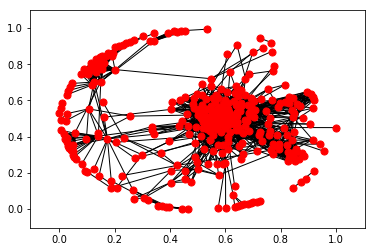

In [6]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

In [7]:
adj = nx.adjacency_matrix(g) # get adjacency matrix in sparse format
features = df.values # features matrix

## 2. Data Preprocessing

In [8]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [9]:
# Tensorflow Settings (hyperparams) - ONLY RUN THIS CELL ONCE

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0.2, 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_vae', 'Model string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

In [10]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [11]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)

In [12]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

## 3. Initialize VAE Model

In [13]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [14]:
# How much to weigh positive examples (true edges) in cost print_function
  # Want to weigh less-frequent classes higher, so as to prevent model output bias
  # pos_weight = (num. negative samples / (num. positive samples)
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()

# normalize (scale) average weighted cost
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [15]:
# Create VAE model
with tf.name_scope('optimizer'):
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

    opt = OptimizerVAE(preds=model.reconstructions,
                               labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                           validate_indices=False), [-1]),
                               model=model, num_nodes=num_nodes,
                               pos_weight=pos_weight,
                               norm=norm)

In [16]:
# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

## 4. Train and Evaluate VAE Model

In [17]:
cost_val = []
acc_val = []
val_roc_score = []

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    # Evaluate predictions
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    # Print results for this epoch
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Print final results
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.51754 train_acc= 0.48541 val_roc= 0.79885 val_ap= 0.79083 time= 0.05595
Epoch: 0002 train_loss= 1.58582 train_acc= 0.48132 val_roc= 0.79987 val_ap= 0.79148 time= 0.01955
Epoch: 0003 train_loss= 1.52804 train_acc= 0.47903 val_roc= 0.80198 val_ap= 0.79287 time= 0.01940
Epoch: 0004 train_loss= 1.53159 train_acc= 0.49636 val_roc= 0.80480 val_ap= 0.79576 time= 0.02071
Epoch: 0005 train_loss= 1.42820 train_acc= 0.49126 val_roc= 0.80762 val_ap= 0.79739 time= 0.02255
Epoch: 0006 train_loss= 1.41830 train_acc= 0.49302 val_roc= 0.80870 val_ap= 0.79750 time= 0.02014
Epoch: 0007 train_loss= 1.40206 train_acc= 0.49510 val_roc= 0.80915 val_ap= 0.79741 time= 0.03099
Epoch: 0008 train_loss= 1.38747 train_acc= 0.48599 val_roc= 0.80576 val_ap= 0.79462 time= 0.03563
Epoch: 0009 train_loss= 1.39551 train_acc= 0.49256 val_roc= 0.80275 val_ap= 0.79166 time= 0.02807
Epoch: 0010 train_loss= 1.33747 train_acc= 0.49227 val_roc= 0.79968 val_ap= 0.78983 time= 0.06670
Epoch: 0011 train_lo

Epoch: 0089 train_loss= 0.58135 train_acc= 0.53644 val_roc= 0.82746 val_ap= 0.80673 time= 0.04424
Epoch: 0090 train_loss= 0.58172 train_acc= 0.52773 val_roc= 0.82624 val_ap= 0.80267 time= 0.03378
Epoch: 0091 train_loss= 0.57786 train_acc= 0.52489 val_roc= 0.82598 val_ap= 0.80344 time= 0.02988
Epoch: 0092 train_loss= 0.58148 train_acc= 0.52560 val_roc= 0.82432 val_ap= 0.80143 time= 0.03112
Epoch: 0093 train_loss= 0.58616 train_acc= 0.53043 val_roc= 0.82413 val_ap= 0.80247 time= 0.02866
Epoch: 0094 train_loss= 0.57774 train_acc= 0.52839 val_roc= 0.82400 val_ap= 0.80232 time= 0.02642
Epoch: 0095 train_loss= 0.57730 train_acc= 0.53995 val_roc= 0.82528 val_ap= 0.80376 time= 0.02359
Epoch: 0096 train_loss= 0.58572 train_acc= 0.53517 val_roc= 0.82618 val_ap= 0.80509 time= 0.02438
Epoch: 0097 train_loss= 0.57429 train_acc= 0.54046 val_roc= 0.82592 val_ap= 0.80702 time= 0.02800
Epoch: 0098 train_loss= 0.57616 train_acc= 0.53866 val_roc= 0.82656 val_ap= 0.80812 time= 0.04319
Epoch: 0099 train_lo

Epoch: 0177 train_loss= 0.54678 train_acc= 0.55146 val_roc= 0.86323 val_ap= 0.85555 time= 0.01986
Epoch: 0178 train_loss= 0.54787 train_acc= 0.54639 val_roc= 0.86368 val_ap= 0.85610 time= 0.02304
Epoch: 0179 train_loss= 0.54967 train_acc= 0.54616 val_roc= 0.86355 val_ap= 0.85737 time= 0.02611
Epoch: 0180 train_loss= 0.54753 train_acc= 0.55375 val_roc= 0.86336 val_ap= 0.85737 time= 0.02072
Epoch: 0181 train_loss= 0.54987 train_acc= 0.54870 val_roc= 0.86272 val_ap= 0.85687 time= 0.02568
Epoch: 0182 train_loss= 0.54788 train_acc= 0.55635 val_roc= 0.86246 val_ap= 0.85585 time= 0.02220
Epoch: 0183 train_loss= 0.54789 train_acc= 0.55157 val_roc= 0.86202 val_ap= 0.85414 time= 0.02103
Epoch: 0184 train_loss= 0.55427 train_acc= 0.54506 val_roc= 0.86163 val_ap= 0.85558 time= 0.02251
Epoch: 0185 train_loss= 0.54961 train_acc= 0.55184 val_roc= 0.86176 val_ap= 0.85441 time= 0.02577
Epoch: 0186 train_loss= 0.54658 train_acc= 0.55222 val_roc= 0.86176 val_ap= 0.85583 time= 0.02258
Epoch: 0187 train_lo